Problem Statement:
Generate singles stream

Definitions:
Stream is a rhythm game pattern where no two consecutive chords contain the same tracks (aka lanes).
Singles are chords that contain only one track.

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

Generate stream directly

In [10]:
g = torch.manual_seed(1337)
chart = []
prev_track = 0
for _ in range(100):
    while (track := torch.randint(1, 5, (1,), generator=g).item()) == prev_track: pass
    chart.append(track)
    prev_track = track
print(len(chart))

100


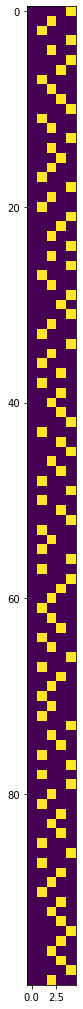

In [16]:
fig, ax = plt.subplots(figsize=(5, 18))
ax.imshow(F.one_hot(torch.tensor(chart), num_classes=5))

Generate stream by sampling from a statistical bigram model

In [17]:
tracks = [".", "1", "2", "3", "4"]
itos = {i:s for i,s in enumerate(tracks)}
stoi = {s:i for i,s in itos.items()}

In [21]:
examples = []

for t in tracks[1:]:
    examples.append((".", t))

for t1 in tracks[1:]:
    for t2 in tracks[1:]:
        if t1 == t2:
            continue
        examples.append((t1, t2))

In [28]:
N = torch.zeros(5, 5).int().tolist()

for t1, t2 in examples:
    ix1 = stoi[t1]
    ix2 = stoi[t2]
    N[ix1][ix2] += 1

N = torch.tensor(N)

In [30]:
P = N.float()
P /= P.sum(axis=1, keepdim=True)

In [37]:
g = torch.manual_seed(1337)

track = 0
chart = []
for _ in range(100):
    track = torch.multinomial(P[track], num_samples=1, replacement=True, generator=g).item()
    chart.append(track)
print(len(chart))

100


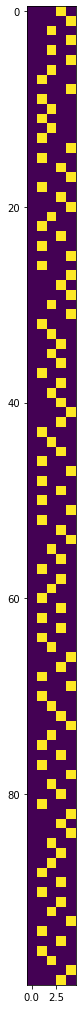

In [38]:
fig, ax = plt.subplots(figsize=(5, 18))
ax.imshow(F.one_hot(torch.tensor(chart), num_classes=5))

In [47]:
xs = F.one_hot(torch.tensor([stoi[t[0]] for t in examples]), num_classes=5).float()
ys = torch.tensor([stoi[t[1]] for t in examples])

In [50]:
probs = xs @ P
loss = -probs[torch.arange(len(xs)), ys].log().mean()
loss

tensor(1.1705)

Generate stream by sampling from a neural net bigram model

In [53]:
torch.manual_seed(1337)
W = torch.randn(5, 5)

In [55]:
N = W.exp()
P = N / N.sum(axis=1, keepdim=True)

g = torch.manual_seed(1337)

track = 0
chart = []
for _ in range(100):
    track = torch.multinomial(P[track], num_samples=1, replacement=True, generator=g).item()
    chart.append(track)
print(len(chart))

100


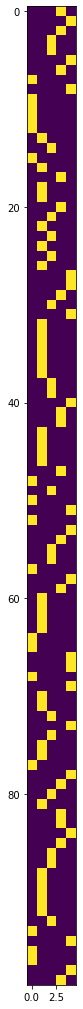

In [56]:
fig, ax = plt.subplots(figsize=(5, 18))
ax.imshow(F.one_hot(torch.tensor(chart), num_classes=5))

In [63]:
torch.manual_seed(1337)
W = torch.randn(5, 5, requires_grad=True)

epochs = 10000
learning_rate = 5
for _ in range(epochs):
    logits = xs @ W
    loss = F.cross_entropy(logits, ys)

    W.grad = None
    loss.backward()

    W.data -= learning_rate * W.grad
print(loss.item())
# target: 1.1705

1.1706448793411255


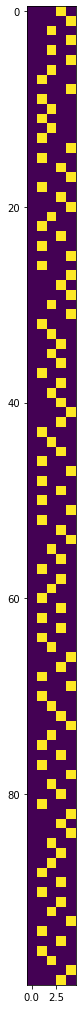

In [64]:
N = W.exp()
P = N / N.sum(axis=1, keepdim=True)

g = torch.manual_seed(1337)

track = 0
chart = []
for _ in range(100):
    track = torch.multinomial(P[track], num_samples=1, replacement=True, generator=g).item()
    chart.append(track)

fig, ax = plt.subplots(figsize=(5, 18))
ax.imshow(F.one_hot(torch.tensor(chart), num_classes=5))

In [66]:
torch.set_printoptions(sci_mode=False)
P

tensor([[    0.0001,     0.2500,     0.2500,     0.2500,     0.2500],
        [    0.0001,     0.0001,     0.3333,     0.3333,     0.3333],
        [    0.0001,     0.3333,     0.0001,     0.3333,     0.3333],
        [    0.0001,     0.3333,     0.3333,     0.0001,     0.3333],
        [    0.0001,     0.3333,     0.3333,     0.3333,     0.0001]],
       grad_fn=<DivBackward0>)